# Exercise 1: Selection Strategies in a Pool-Based Setting
___

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from parzen_window_classifier import PWC

plt.style.use('ggplot')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

<IPython.core.display.Javascript object>


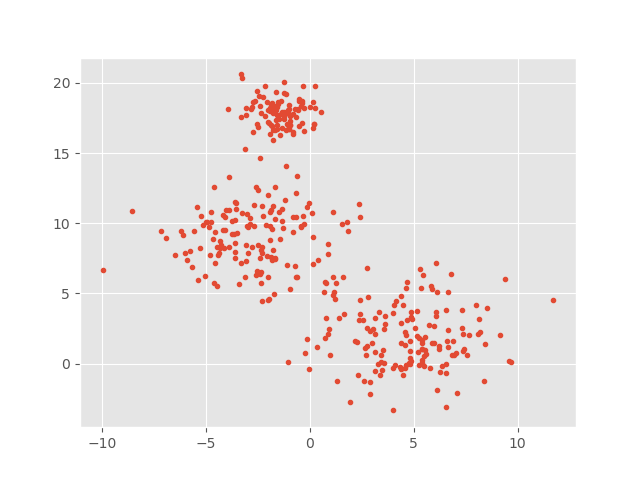

In [10]:
%matplotlib notebook
"""Create Dataset."""
X, y = make_blobs(300, centers=2, cluster_std=2.3, random_state=RANDOM_SEED)
new_center = max(X, key=lambda x: x[1])
size = 100
X1, y1 = np.c_[np.random.normal(loc=new_center[0], size=size),
               np.random.normal(loc=new_center[1], size=size)], np.ones(size)
X, y = np.r_[X, X1], np.r_[y, y1].astype(int)


## Plot dataset method
def plot_dataset(x):
    plt.plot(x[:, 0], x[:, 1], '.')


def plot_dataset_with_class(x, y):
    uniques = np.unique(y)
    [plt.plot(x[:, 0][y == unique], x[:, 1][y == unique], '.') for unique in uniques]

plt.figure()
plot_dataset(X)
plt.show()

In [11]:
# visualize sampling and decision boundary
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, X, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

## Task 1: 
___
Describe the different steps in a general pool-based active learning
scenario and find each step in the following code which visualizes the
random sampling strategy.


In [14]:
## plot sampling
def plot_sampling(X, y, clf, selection_strategy, num_queries=5, time_between_sampling=0.5, ax=None):
    """
    Visualization of the sampling with the decision boundary.

    Parameters
    ----------
    X: array_like
        Numpy array with samples as rows and features as columns.
    y: array_like
        Corresponding labels of the samples.
    clf: sklearn classifier
        Classifier that will be used in the AL process.
    selection_strategy: function
        Method that queries a sample and return an index.
    num_queries: int
        Number of AL queries.
    """
    # Define labeled and unlabeled pool
    X_unlabeled, y_unlabeled = X, y 
    X_labeled, y_labeled = list(), list()
    
    if ax:
        ax.cla()
        countour = None
        plot_dataset_with_class(X, y)

    for step in range(num_queries):
        
        num_classes = len(np.unique(y_labeled))
        
        if num_classes < 2:
            query_idx = random_sampling(X_unlabeled)
            query_sample, query_label = X_unlabeled[query_idx], y_unlabeled[query_idx]
            
            X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
            y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
            
            X_labeled.append(query_sample)
            y_labeled.append(query_label)
            
            if ax:
                ax.plot(query_sample[0], query_sample[1], 'oy', markeredgewidth=1, 
                        markeredgecolor=(0, 0, 0, 1), markersize=8)
                
        else:
            clf.fit(np.array(X_labeled), np.array(y_labeled).astype(int))
            
                
            if selection_strategy.__name__ == 'random_sampling':
                query_idx = selection_strategy(X_unlabeled)
            elif selection_strategy.__name__ == 'uncertainty_sampling':
                query_idx = selection_strategy(X_unlabeled, clf)
            elif selection_strategy.__name__ == 'ensemble_based_sampling':
                query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled)
            elif selection_strategy.__name__ == 'expected_error_reduction':
                query_idx = selection_strategy(X_unlabeled, X_labeled, y_labeled, clf)

            # Implement your own strategies here! 

            query_sample, query_label = X_unlabeled[query_idx], y_unlabeled[query_idx]
            
            X_unlabeled = np.delete(X_unlabeled, query_idx, axis=0)
            y_unlabeled = np.delete(y_unlabeled, query_idx, axis=0)
            
            X_labeled.append(query_sample)
            y_labeled.append(query_label)

            if ax: 
                clf.fit(np.array(X_labeled), np.array(y_labeled).astype(int))
                # plot decision boundary
                if countour is not None:
                    for coll in countour.collections:
                        coll.remove()
                        
                countour = plot_contours(plt.gca(), clf, X, alpha=0.5, cmap=plt.cm.coolwarm)

                ax.plot(query_sample[0], query_sample[1], 'oy', markeredgewidth=1,
                        markeredgecolor=(0, 0, 0, 1), markersize=8)

        if ax: 
            plt.gcf().canvas.draw()
            plt.pause(time_between_sampling)
    
def random_sampling(pool):
    """Randomly selects an instances.

    Parameters
    ----------
    X: array_like
        Array of all unlabeled instances.

    Returns
    -------
    index: int
        Random index of all instances.
    """
    return np.random.randint(len(pool))

<IPython.core.display.Javascript object>


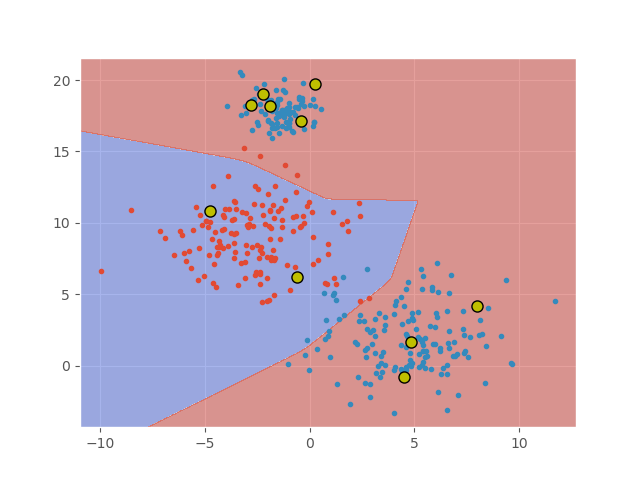

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
fig.canvas.draw()

In [17]:
# run this code and watch the figure above
clf = PWC(n_classes=2, gamma=1)
plot_sampling(X, y, clf, random_sampling, num_queries=10, time_between_sampling=.5, ax=plt.gca())

## Task 2:
___
Use the code from above and implement the "selection_strategy" for the following
algorithms mentioned in the lecture:
- Uncertainty Sampling,
- Ensemble-based Sampling,
- Expected Error Reduction.

### Uncertainty Sampling

In [5]:
def uncertainty_sampling():
    pass

### Ensemble-based Sampling

In [6]:
def ensemble_based_sampling():
    pass

### Expected Error Reduction

In [7]:
def expected_error_reduction():
    pass

## Task 3:
___
Visualize the behavior of each of the previously mentioned methods
using the tool from task 1. Explain if which of the following influence
factors are used (mathematically and visually):
- Decision boundary
- Reliability 
- Influence
- Class distribution

In [8]:
########
# Code #
########

## Task 4:
___
Discussion: Which of the previous methods works best and why? How could
this be?

In [9]:
########
# Text #
########